<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#使用データ" data-toc-modified-id="使用データ-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>使用データ</a></span></li><li><span><a href="#フィルター法（単変量統計）" data-toc-modified-id="フィルター法（単変量統計）-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>フィルター法（単変量統計）</a></span><ul class="toc-item"><li><span><a href="#SelectKBest" data-toc-modified-id="SelectKBest-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>SelectKBest</a></span></li><li><span><a href="#SelectPercentile" data-toc-modified-id="SelectPercentile-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>SelectPercentile</a></span></li><li><span><a href="#GenericUnivariateSelect" data-toc-modified-id="GenericUnivariateSelect-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span><a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.GenericUnivariateSelect.html" target="_blank">GenericUnivariateSelect</a></a></span></li></ul></li><li><span><a href="#ラッパー法（反復特徴量選択）" data-toc-modified-id="ラッパー法（反復特徴量選択）-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>ラッパー法（反復特徴量選択）</a></span><ul class="toc-item"><li><span><a href="#RFE(Recursive-Feature-Elimination;-再帰的特徴量削減）" data-toc-modified-id="RFE(Recursive-Feature-Elimination;-再帰的特徴量削減）-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span><a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html" target="_blank">RFE(Recursive Feature Elimination; 再帰的特徴量削減）</a></a></span></li><li><span><a href="#RFECV" data-toc-modified-id="RFECV-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span><a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html" target="_blank">RFECV</a></a></span></li></ul></li><li><span><a href="#Boruta" data-toc-modified-id="Boruta-4"><span class="toc-item-num">4&nbsp;&nbsp;</span><a href="https://pypi.org/project/Boruta/" target="_blank">Boruta</a></a></span></li><li><span><a href="#組み込み法（モデルベース特徴量選択）" data-toc-modified-id="組み込み法（モデルベース特徴量選択）-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>組み込み法（モデルベース特徴量選択）</a></span><ul class="toc-item"><li><span><a href="#SelectFromModel" data-toc-modified-id="SelectFromModel-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>SelectFromModel</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

# matplotの日本語表示
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'IPAexGothic'

# 最大表示行数
pd.set_option('display.max_rows', 250)

# 最大表示列数
pd.set_option('display.max_columns', 250)

# warningの抑止
import warnings
warnings.filterwarnings('ignore')

# [特徴量選択（Feature selection）](https://scikit-learn.org/stable/modules/feature_selection.html)


モデルの性能に寄与する特徴量の部分集合を取り出す作業を特徴量選択という。  
代表的には3種類の戦略がある
（単変量統計量は次元の削減に使う程度で、基本は使用しない）  
ステップワイズは反復特徴量選択に属する。  
多分、ラッパー法のBorutaの利用が現実的

|名称|概説|
|:---|:---|
|単変量統計量　フィルター法 (Filter Method)|統計的な物差しにもとづいて特徴量を評価す|
|反復特徴量選択　ラッパー法 (Wrapper Method)|機械学習のモデルを用いて特徴量を評価|
|モデルベース特徴量選択　組み込み法 (Embedding Method)|学習するタイミングで特徴量を評価|


[sklearn.feature_selection による特徴量選択](https://qiita.com/rockhopper/items/a68ceb3248f2b3a41c89)が良くまとまっている。

## 使用データ
ウィスコンシン乳癌データセットを使用する

In [2]:
from sklearn import datasets

# Load the digits dataset
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

breast_cancer.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

## フィルター法（単変量統計）

各説明変数と目的変数との間の関係を計算し、最も高い確信度で関連している特徴量を選択する。  
モデルを使っていない事と特徴量の数を事前に決めなければいけない事に注意。

### SelectKBest

説明変数のうち上位k個を選択する。  
引数 k に最終的に使用する特徴量の数を指定し、引数 score_func は
- 分類：f_classif（デフォルト値）
- 回帰：f_regression

を通常指定する。

In [3]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

# 分類にたいして、10個の特徴量を選択
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X, y)

# 各特徴量の選択有無（True・False）か取得
mask = selector.get_support()
p_value = selector.pvalues_

# 選択した特徴量の列のみ取得
X_selected = selector.transform(X)
print("選択前={}, 選択後={}".format(X.shape[1], X_selected.shape[1]))

pd.DataFrame(data=[mask, p_value], index=["feature-selected", "p-value"], columns=breast_cancer.feature_names)

選択前=30, 選択後=10


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
feature-selected,True,False,True,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,True,True,False,False
p-value,8.46594e-96,4.05864e-25,8.43625e-101,4.73456e-88,1.05185e-18,3.93826e-56,9.96656e-84,7.10115e-116,5.73338e-16,0.759937,9.73895e-50,0.843332,1.65191e-47,5.89552e-46,0.110297,9.97599e-13,8.26018e-10,3.07231e-24,0.876642,0.0630736,8.48229e-116,1.07806e-30,5.7714e-119,2.82885e-97,6.57514e-26,7.06982e-55,2.46466e-72,1.9691e-124,2.95112e-25,2.31643e-15


### SelectPercentile

説明変数のうち上位k%を選択する。  
引数 percentile に選択する特徴量の割合（0%～100%）を指定する。

In [4]:
from sklearn.feature_selection import SelectPercentile

# 特徴量のうち40%を選択
selector = SelectPercentile(score_func=f_classif, percentile=40)
selector.fit(X, y)

# 各特徴量の選択有無（True・False）か取得
mask = selector.get_support()
p_value = selector.pvalues_

# 選択した特徴量の列のみ取得
X_selected = selector.transform(X)
print("選択前={}, 選択後={}".format(X.shape[1], X_selected.shape[1]))

pd.DataFrame(data=[mask, p_value], index=["feature-selected", "p-value"], columns=breast_cancer.feature_names)

選択前=30, 選択後=12


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
feature-selected,True,False,True,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,True,True,True,False,False
p-value,8.46594e-96,4.05864e-25,8.43625e-101,4.73456e-88,1.05185e-18,3.93826e-56,9.96656e-84,7.10115e-116,5.73338e-16,0.759937,9.73895e-50,0.843332,1.65191e-47,5.89552e-46,0.110297,9.97599e-13,8.26018e-10,3.07231e-24,0.876642,0.0630736,8.48229e-116,1.07806e-30,5.7714e-119,2.82885e-97,6.57514e-26,7.06982e-55,2.46466e-72,1.9691e-124,2.95112e-25,2.31643e-15


### [GenericUnivariateSelect](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.GenericUnivariateSelect.html)

>Univariate feature selector with configurable strategy.（コンフィグ可能な戦略を持った単変量セレクタ）

要はSelectKBest、SelectPercentileを汎用化したセレクタ。  
mode でモード(‘percentile’, ‘k_best’, ‘fpr’, ‘fdr’, ‘fwe’) 、param で各モードのパラメータを設定する。

```python
selector = GenericUnivariateSelect(mode='percentile', score_func=f_regression, param=40)
```
と
```python
selector = SelectPercentile(score_func=f_regression, percentile=40) 
```
は同値

## ラッパー法（反復特徴量選択）

### [RFE(Recursive Feature Elimination; 再帰的特徴量削減）](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)

In [5]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# 特徴量を5個選択
selector = RFE(RandomForestClassifier(), n_features_to_select=5)
selector.fit(X, y)

# 各特徴量の選択有無（True・False）か取得
mask = selector.get_support()
ranking = selector.ranking_

# 選択した特徴量の列のみ取得
X_selected = selector.transform(X)
print("選択前={}, 選択後={}".format(X.shape[1], X_selected.shape[1]))

pd.DataFrame(data=[mask, ranking], index=["feature-selected", "ranking"], columns=breast_cancer.feature_names)

選択前=30, 選択後=5


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
feature-selected,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,True,False,False
ranking,8,4,9,5,14,17,2,1,25,26,16,22,13,7,19,23,18,21,20,24,1,3,1,1,10,11,6,1,12,15


### [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)

交差検証（クロスバリデーション）を利用したRFE
恐らく、これが最適解（Borutaという方法もあるらしい）

scoringの指定の仕方は[ここ](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

In [6]:
# 特徴量の数
max_feature_num = len(breast_cancer.feature_names)
max_feature_num

30

In [7]:
from sklearn.feature_selection import RFECV

# 交差検証は5分割、スコアリングはF値
selector = RFECV(RandomForestClassifier(), scoring='f1', cv=3)
selector.fit(X, y)

# 各特徴量の選択有無（True・False）か取得
mask = selector.get_support()
ranking = selector.ranking_

# 選択した特徴量の列のみ取得
X_selected = selector.transform(X)
print("選択前={}, 選択後={}".format(X.shape[1], X_selected.shape[1]))

pd.DataFrame(data=[mask, ranking], index=["feature-selected", "ranking"], columns=breast_cancer.feature_names)

選択前=30, 選択後=15


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
feature-selected,True,True,True,True,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,True,True,True,True,True,True,True,True,False,False
ranking,1,1,1,1,4,10,1,1,14,12,5,9,6,1,16,13,8,11,15,7,1,1,1,1,1,1,1,1,2,3


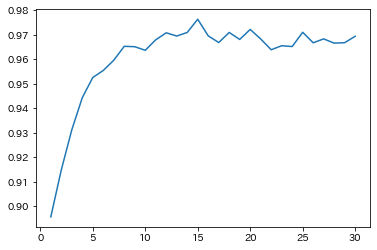

In [8]:
# 特徴量の数とスコアの関係をプロット
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)

## [Boruta](https://pypi.org/project/Boruta/)

RandomForestを用いた特徴量選択。RFECVより強力らしい

[論文](https://www.google.co.jp/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=0ahUKEwiEzMP4p9naAhWBk5QKHbRjC9oQFggoMAA&url=https%3A%2F%2Fwww.jstatsoft.org%2Farticle%2Fview%2Fv036i11%2Fv36i11.pdf&usg=AOvVaw3tyiHN0BCe2fkkAA6xEVDE)

In [9]:
from boruta import BorutaPy

selector = BorutaPy(RandomForestClassifier(), n_estimators=10)
selector.fit(X, y)

# 各特徴量の選択有無（True・False）か取得

mask = selector.support_
ranking = selector.ranking_

# 選択した特徴量の列のみ取得
X_selected = selector.transform(X)

print("選択前={}, 選択後={}".format(X.shape[1], selector.n_features_))
print("選択前={}, 選択後={}".format(X.shape[1], X_selected.shape[1]))

pd.DataFrame(data=[mask, ranking], index=["feature-selected", "ranking"], columns=breast_cancer.feature_names)

選択前=30, 選択後=16
選択前=30, 選択後=16


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
feature-selected,True,True,True,True,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,False
ranking,1,1,1,1,3,2,1,1,6,5,2,10,3,1,10,12,3,8,8,11,1,1,1,1,1,1,1,1,1,3


## 組み込み法（モデルベース特徴量選択）

モデルで得られる特徴量の重要性をあらわした feature_importances_ 属性を利用して特徴量を選択する。

### SelectFromModel

In [10]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# 重要度が median 以上のものを選択
selector = SelectFromModel(RandomForestClassifier(), threshold="median")    
selector.fit(X, y)

# 各特徴量の選択有無（True・False）か取得
mask = selector.get_support()

# 選択した特徴量の列のみ取得
X_selected = selector.transform(X)
print("選択前={}, 選択後={}".format(X.shape[1], X_selected.shape[1]))

pd.DataFrame(data=[mask], index=["feature-selected"], columns=breast_cancer.feature_names)

選択前=30, 選択後=15


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
feature-selected,True,True,True,True,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,True,True,True,True,True,True,True,True,False,False
